In [13]:
import pylab as plt
import xarray as xr
import pint_xarray
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import seaborn as sns

from pism_ragis.observations import load_imbie, load_mouginot

In [34]:
reference_year = 1992
golden_ratio = (1 + np.sqrt(5)) / 2

In [15]:
    mass_cumulative_varname = "Cumulative ice sheet mass change (Gt)"
    mass_cumulative_uncertainty_varname = (
        "Cumulative ice sheet mass change uncertainty (Gt)"
    )
    mass_flux_varname = "Rate of ice sheet mass change (Gt/yr)"
    mass_flux_uncertainty_varname = "Rate of ice sheet mass change uncertainty (Gt/yr)"

    discharge_cumulative_varname = "Cumulative ice discharge anomaly (Gt)"
    discharge_cumulative_uncertainty_varname = (
        "Cumulative ice discharge anomaly uncertainty (Gt)"
    )
    discharge_flux_varname = "Rate of ice discharge (Gt/yr)"
    discharge_flux_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"

    smb_cumulative_varname = "Cumulative surface mass balance anomaly (Gt)"
    smb_cumulative_uncertainty_varname = (
        "Cumulative surface mass balance anomaly uncertainty (Gt)"
    )
    smb_flux_varname = "Rate of surface mass balance (Gt/yr)"
    smb_flux_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

    basal_flux_varname = "tendency_of_ice_mass_due_to_basal_mass_flux"
    basal_grounded_flux_varname = "tendency_of_ice_mass_due_to_basal_mass_flux_grounded"
    basal_floating_flux_varname = "tendency_of_ice_mass_due_to_basal_mass_flux_floating"

    sim_mass_cumulative_varname = "ice_mass"
    sim_mass_flux_varname = "tendency_of_ice_mass"
    sim_smb_flux_varname = "tendency_of_ice_mass_due_to_surface_mass_flux"
    sim_discharge_flux_varname = "ice_mass_transport_across_grounding_line"


In [16]:
mouginot_url = Path("/mnt/storstrommen/data/mouginot/pnas.1904242116.sd02.xlsx")
mouginot_url = Path("/Users/andy/Google Drive/My Drive/data/mouginot_discharge/pnas.1904242116.sd02.xlsx")

# Load observations
imbie = load_imbie()
mou = load_mouginot(url=mouginot_url, norm_year=reference_year)
mou[discharge_flux_varname] = -mou[discharge_flux_varname]
mou_gis = mou[mou["Basin"] == "GIS"]

imbie_mean = imbie[imbie.Date.between("1992-1-1", "2012-1-1")][
[
    mass_flux_uncertainty_varname,
    smb_flux_uncertainty_varname,
    discharge_flux_uncertainty_varname,
    ]
].mean()
mou_mean = mou[mou.Date.between("1992-1-1", "2012-1-1")][
[
    mass_flux_uncertainty_varname,
    smb_flux_uncertainty_varname,
    discharge_flux_uncertainty_varname,        ]
].mean()
u_ratio = imbie_mean / mou_mean / 2
sigma_adjusted = np.maximum(u_ratio, 1)

In [17]:
imbie_2021 = pd.read_csv("/Volumes/pism/data/imbie/imbie_greenland_2021_Gt.csv").rename(columns={'Cumulative mass balance (Gt)': mass_cumulative_varname,
                                                                                                 'Cumulative mass balance uncertainty (Gt)': mass_cumulative_uncertainty_varname})
y = imbie_2021["Year"].astype("int")
imbie_2021["Date"] = pd.to_datetime({"year": y, "month": 1, "day": 1}) + pd.to_timedelta(
    (imbie_2021["Year"] - imbie_2021["Year"].astype("int")) * 3.15569259747e7, "seconds"
)

In [18]:
ds_ctrl = xr.open_mfdataset("../analysis/2024_07_ragis_ctrl/basins_sums_ensemble_RAGIS_id_BM-*.nc")
ds_ctrl = ds_ctrl.sel(ensemble_id="RAGIS").sel(time=slice("1980-01-01", "2020-01-01"))
ds_ctrl[sim_mass_cumulative_varname] -= ds_ctrl.sel(time=f"{reference_year}-01-01", method="nearest")[sim_mass_cumulative_varname]
ds_ctrl[sim_discharge_flux_varname] += ds_ctrl["tendency_of_ice_mass_due_to_basal_mass_flux_grounded"]
ds_ctrl = ds_ctrl.rolling(time=13).mean()

In [19]:
ds_tw = xr.open_mfdataset("../analysis/2024_07_ragis_tw/basins_sums_ensemble_RAGIS_id_BM-*.nc")
ds_tw = ds_tw.sel(ensemble_id="RAGIS").sel(time=slice("1980-01-01", "2020-01-01"))
ds_tw[sim_mass_cumulative_varname] -= ds_tw.sel(time=f"{reference_year}-01-01", method="nearest")[sim_mass_cumulative_varname]
ds_tw[sim_discharge_flux_varname] += ds_tw["tendency_of_ice_mass_due_to_basal_mass_flux_grounded"]
ds_tw = ds_tw.rolling(time=13).mean()

In [20]:
mb = (ds_tw["tendency_of_ice_mass_due_to_surface_mass_flux"] + ds_tw["ice_mass_transport_across_grounding_line"]).cumsum() / 12
mb -= mb.sel(time=f"{reference_year}-01-01", method="nearest")
mb_with_bmb = (ds_tw["tendency_of_ice_mass_due_to_surface_mass_flux"] + ds_tw["ice_mass_transport_across_grounding_line"] + ds_tw[basal_floating_flux_varname]).cumsum() / 12
mb_with_bmb -= mb_with_bmb.sel(time=f"{reference_year}-01-01", method="nearest")

In [21]:
obs_cmap = sns.color_palette("crest", n_colors=4)
obs_cmap = ["0.4", "0.0", "0.6", "0.0"]
sim_cmap = sns.color_palette("flare", n_colors=len(ds_tw.exp_id))

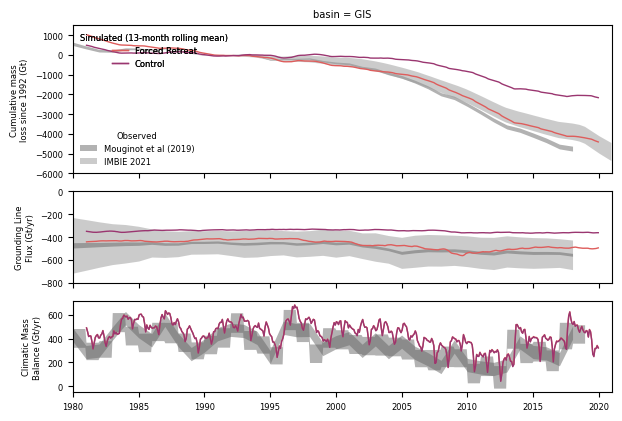

In [36]:
plt.rcParams["font.size"] = 6

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6.2, 4.2), height_ratios=[golden_ratio, 1, 1])
ds_tw_gis = ds_tw.sel(basin="GIS")
sim_labels = []
exp_labels = ["Forced Retreat", "Control"]
sim_lines = []
for k, exp_id in enumerate(ds_tw_gis.exp_id):
    exp = ds_tw_gis.sel(exp_id=exp_id)
    sim_l = axs[0].plot(exp.time, exp[sim_mass_cumulative_varname], color=sim_cmap[k], lw=1, label=exp_labels[k])
    sim_lines.append(sim_l[0])
    axs[1].plot(exp.time, exp[sim_discharge_flux_varname], color=sim_cmap[k], lw=1)
    axs[2].plot(exp.time, exp[sim_smb_flux_varname], color=sim_cmap[k], lw=1)
mou_ci = axs[0].fill_between(mou_gis["Date"], 
                mou_gis[mass_cumulative_varname] - mou_gis[mass_cumulative_uncertainty_varname], 
                mou_gis[mass_cumulative_varname] + mou_gis[mass_cumulative_uncertainty_varname], color=obs_cmap[0], alpha=0.5, lw=0, 
                    label="Mouginot et al (2019)")
# axs[0].plot(mou_gis["Date"], mou_gis["Cumulative ice sheet mass change (Gt)"], color=obs_cmap[1], lw=1)
imbie_ci = axs[0].fill_between(imbie_2021["Date"], 
                imbie_2021[mass_cumulative_varname] - imbie_2021[mass_cumulative_uncertainty_varname], 
                imbie_2021[mass_cumulative_varname] + imbie_2021[mass_cumulative_uncertainty_varname], color=obs_cmap[2], alpha=0.5, lw=0,
                   label="IMBIE 2021")
#axs[0].plot(imbie_2021["Date"], imbie_2021[mass_cumulative_varname], color=obs_cmap[3], lw=1)

axs[1].fill_between(mou_gis["Date"], 
                mou_gis[discharge_flux_varname] - sigma_adjusted[discharge_flux_uncertainty_varname] * mou_gis[discharge_flux_uncertainty_varname], 
                mou_gis[discharge_flux_varname] + sigma_adjusted[discharge_flux_uncertainty_varname] * mou_gis[discharge_flux_uncertainty_varname], 
                    color=obs_cmap[2], alpha=0.5, lw=0)
# axs[1].fill_between(imbie["Date"], 
#                 imbie[discharge_flux_varname] - imbie[discharge_flux_uncertainty_varname], 
#                 imbie[discharge_flux_varname] + imbie[discharge_flux_uncertainty_varname], 
#                     color=obs_cmap[0], alpha=0.5, lw=0)
axs[1].fill_between(mou_gis["Date"], 
                mou_gis[discharge_flux_varname] - mou_gis[discharge_flux_uncertainty_varname], 
                mou_gis[discharge_flux_varname] + mou_gis[discharge_flux_uncertainty_varname], 
                    color=obs_cmap[0], alpha=0.5, lw=0)
axs[2].fill_between(imbie["Date"], 
                imbie[smb_flux_varname] - imbie[smb_flux_uncertainty_varname], 
                imbie[smb_flux_varname] + imbie[smb_flux_uncertainty_varname], 
                    color=obs_cmap[0], alpha=0.5, lw=0)
axs[2].fill_between(mou_gis["Date"], 
                mou_gis[smb_flux_varname] - mou_gis[smb_flux_uncertainty_varname], 
                mou_gis[smb_flux_varname] + mou_gis[smb_flux_uncertainty_varname], 
                    color=obs_cmap[0], alpha=0.5, lw=0)
# axs[1].plot(mou_gis["Date"], mou_gis[discharge_flux_varname], color=obs_cmap[0], alpha=0.5, lw=1, )

legend_obs = axs[0].legend(handles=[mou_ci, imbie_ci], loc="lower left",
                       title="Observed")
legend_obs.get_frame().set_linewidth(0.0)
legend_obs.get_frame().set_alpha(0.0)

legend_sim = axs[0].legend(handles=sim_lines, loc="upper left",
                               title="Simulated (13-month rolling mean)")
legend_sim.get_frame().set_linewidth(0.0)
legend_sim.get_frame().set_alpha(0.0)

axs[0].add_artist(legend_obs)
axs[0].add_artist(legend_sim)

axs[0].set_ylim(-6000, 1500)
axs[0].xaxis.set_tick_params(labelbottom=False)

axs[0].set_ylabel(f"Cumulative mass\nloss since {reference_year} (Gt)")
axs[0].set_xlabel("")
axs[0].set_title("basin = GIS")
axs[1].set_title("")
axs[1].set_ylim(-800, 00)
axs[1].set_ylabel("Grounding Line\nFlux (Gt/yr)")
axs[2].set_ylabel("Climatic Mass\nBalance (Gt/yr)")
axs[-1].set_xlim(np.datetime64("1980-01-01"), np.datetime64("2021-01-01"))
fig.tight_layout()
fig.savefig("GIS_mass_accounting.pdf")

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.2, 6.2), height_ratios=[3, 3])
labels = []
f = ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_mass_cumulative_varname].plot.line(x="time", ax=axs[0], label="ice_mass")
labels.append(f[0].get_label())
f = mb.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45").plot.line(ax=axs[0], label="SMB+D+BMB_grounded")
labels.append(f[0].get_label())
f = mb_with_bmb.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45").plot.line(ax=axs[0], label="SMB+D+BMB_total")
labels.append(f[0].get_label())
axs[0].fill_between(mou_gis["Date"], 
                mou_gis[mass_cumulative_varname] - mou_gis[mass_cumulative_uncertainty_varname], 
                mou_gis[mass_cumulative_varname] + mou_gis[mass_cumulative_uncertainty_varname], color="0.75")
axs[0].plot(mou_gis["Date"], mou_gis["Cumulative ice sheet mass change (Gt)"], color="k", lw=2)

labels_flux = []
f = ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_discharge_flux_varname].plot.line(x="time", add_legend=False, ax=axs[1])
labels_flux.append(f[0].get_label())
f = ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[basal_flux_varname].plot.line(x="time", add_legend=False, ax=axs[1])
labels_flux.append(f[0].get_label())
f = ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[basal_grounded_flux_varname].plot.line(x="time", add_legend=False, ax=axs[1], label="BMB grounded")
labels_flux.append(f[0].get_label())
f = ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[basal_floating_flux_varname].plot.line(x="time", add_legend=False, ax=axs[1], label="BMB floating")
labels_flux.append(f[0].get_label())
axs[0].legend(labels)
axs[1].legend(labels_flux)
axs[1].set_ylabel("Flux\n(Gt/yr)")
axs[-1].set_xlim(np.datetime64("1980-01-01"), np.datetime64("2020-01-01"))

In [7]:
import cartopy

In [9]:
crs = cartopy.crs.RotatedGeodetic(20, 10, central_rotated_longitude=0.0, globe=None)

In [10]:
crs.proj4_params

{'datum': 'WGS84',
 'ellps': 'WGS84',
 'proj': 'ob_tran',
 'o_proj': 'latlon',
 'o_lon_p': 0.0,
 'o_lat_p': 10,
 'lon_0': 200,
 'to_meter': 111319.49079327357}

In [12]:
crs.to_proj4()

/Users/andy/miniforge3/envs/pism-ragis/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


'+proj=ob_tran +o_proj=latlon +o_lon_p=0 +o_lat_p=10 +lon_0=200 +datum=WGS84 +no_defs +type=crs'

In [24]:
imbie

,Year,Rate of ice sheet mass change (Gt/yr),Rate of ice sheet mass change uncertainty (Gt/yr),Cumulative ice sheet mass change (Gt),Cumulative ice sheet mass change uncertainty (Gt),Rate of surface mass balance anomaly (Gt/yr),Rate of surface mass balance anomaly uncertainty (Gt/yr),Cumulative surface mass balance anomaly (Gt),Cumulative surface mass balance anomaly uncertainty (Gt),Rate of ice discharge anomaly (Gt/yr),Rate of ice discharge anomaly uncertainty (Gt/yr),Cumulative ice discharge anomaly (Gt),Cumulative ice discharge anomaly uncertainty (Gt),Rate of surface mass balance (Gt/yr),Rate of ice discharge (Gt/yr),Rate of surface mass balance uncertainty (Gt/yr),Rate of ice discharge uncertainty (Gt/yr),SLE (cm),SLE uncertainty (cm),Date
0,1980.000000,NaN,NaN,NaN,NaN,12.672691,78.709874,1.056058,22.721583,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-01-01 00:00:00.000000000
1,1980.083333,NaN,NaN,NaN,NaN,12.672691,78.709874,2.112115,32.133171,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-01-31 10:29:03.831122155
2,1980.166667,NaN,NaN,NaN,NaN,12.672691,78.709874,3.168173,39.354937,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-03-01 20:58:07.662552845
3,1980.250000,NaN,NaN,NaN,NaN,12.672691,78.709874,4.224230,45.443167,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-04-01 07:27:11.493675000
4,1980.333333,NaN,NaN,NaN,NaN,12.672691,78.709874,5.280288,50.807005,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-05-01 17:56:15.324797155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2018.583333,-143.8,56.8,-3991.865803,344.868007,45.653071,77.031700,-1961.451876,501.907312,-189.453071,95.70853,-2058.785224,547.081162,438.453071,-582.253071,77.031700,95.70853,-1.101204,0.095136,2018-08-02 01:23:26.818472154
464,2018.666667,-143.8,56.8,-4003.849136,345.257579,45.653071,77.031700,-1957.647453,502.399682,-189.453071,95.70853,-2074.572980,547.778369,438.453071,-582.253071,77.031700,95.70853,-1.104510,0.095243,2018-09-01 11:52:30.649902847
465,2018.750000,-143.8,56.8,-4015.832470,345.646711,45.653071,77.031700,-1953.843030,502.891569,-189.453071,95.70853,-2090.360736,548.474689,438.453071,-582.253071,77.031700,95.70853,-1.107816,0.095351,2018-10-01 22:21:34.481024999
466,2018.833333,-143.8,56.8,-4027.815803,346.035406,45.653071,77.031700,-1950.038608,503.382976,-189.453071,95.70853,-2106.148492,549.170127,438.453071,-582.253071,77.031700,95.70853,-1.111122,0.095458,2018-11-01 08:50:38.312147155
